In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
import tqdm
import json
# !{sys.executable} -m pip install opencv-python matplotlib
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


In [2]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import sys
import numpy as np

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
sys.path.append("..")

sam_checkpoint = "/trunk/shared/cuneiform/CuneiformDating/image_classification/segmentation/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.94,
    stability_score_thresh=0.90,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10000,  # Requires open-cv to run post-processing
)

In [6]:
def getFrontCutout(masks,image):
    frontMask = None
    if len(masks) == 0:
        return frontMask
    elif len(masks) == 1:
        frontMask = masks[0]
    elif len(masks) > 2:
        if masks[0]['bbox'][0] <=5 and masks[0]['bbox'][1] <=5:
            #masks[0] is background, choose from 1 or 2
            if masks[1]['area'] > masks[2]['area']*1.5: #masks[1] is much bigger than masks[2]
                frontMask = masks[1]
            elif masks[1]['bbox'][1] < masks[2]['bbox'][1]:  # ycoordinate of front mask will be smaller
                frontMask = masks[1]
            else:
                frontMask = masks[2]

        else:
            frontMask = masks[0]
    else:
        if masks[0]['bbox'][0] <=5 and masks[0]['bbox'][1] <=5:
            frontMask = masks[1]
        else:
            frontMask = masks[0]
    x,y,w,h = frontMask['bbox']
    x,y,w,h = int(x), int(y), int(w), int(h)
    cutout = image[y:y+h, x:x+w]
    return cutout

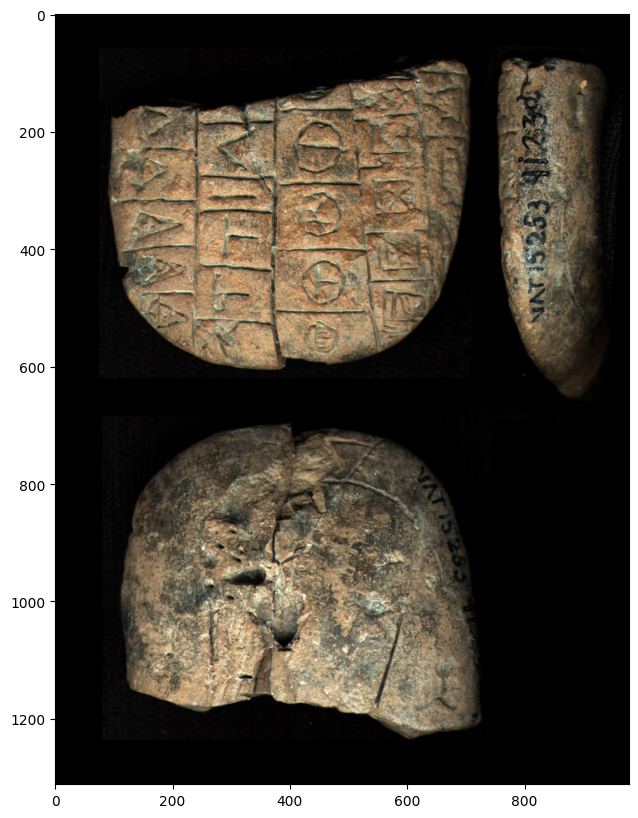

In [3]:
#demo image
image = cv2.imread("/trunk/shared/cuneiform/full_data/images/P000003.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

8


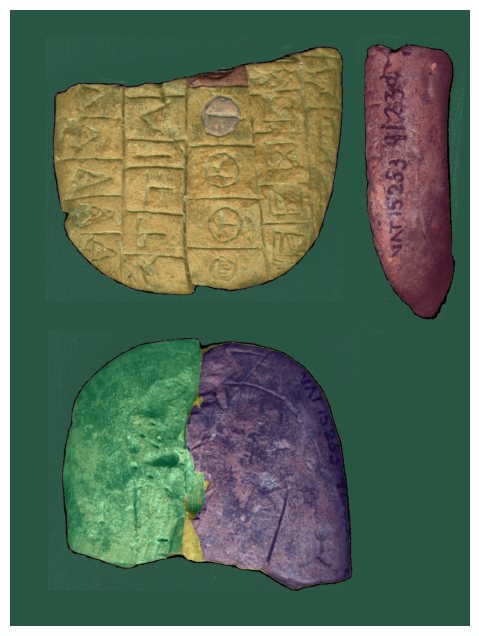

In [8]:
#demo image largest masks
masks = mask_generator.generate(image)
print(len(masks))
masks = sorted(masks, key = lambda d: d['area'], reverse = True )
plt.figure(figsize=(8,8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

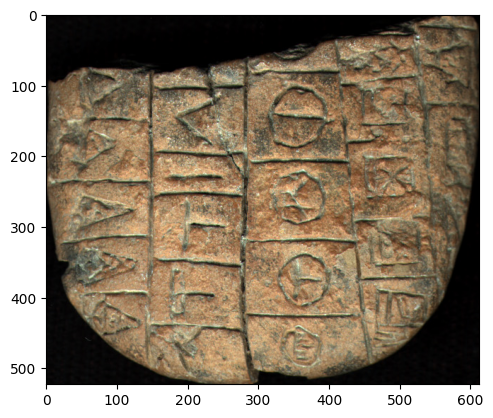

In [9]:
#demo image cutout
x,y,w,h = masks[1]['bbox']
cutout = getFrontCutout(masks,image)
plt.imshow(cutout)

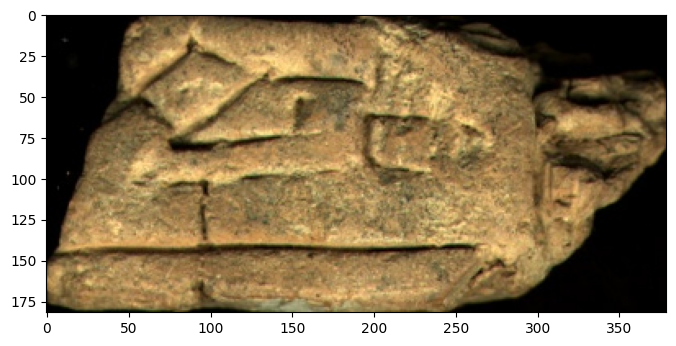

In [12]:
from PIL import Image
image = Image.open("/trunk/shared/cuneiform/full_data/segmented_images/P000109.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(image)

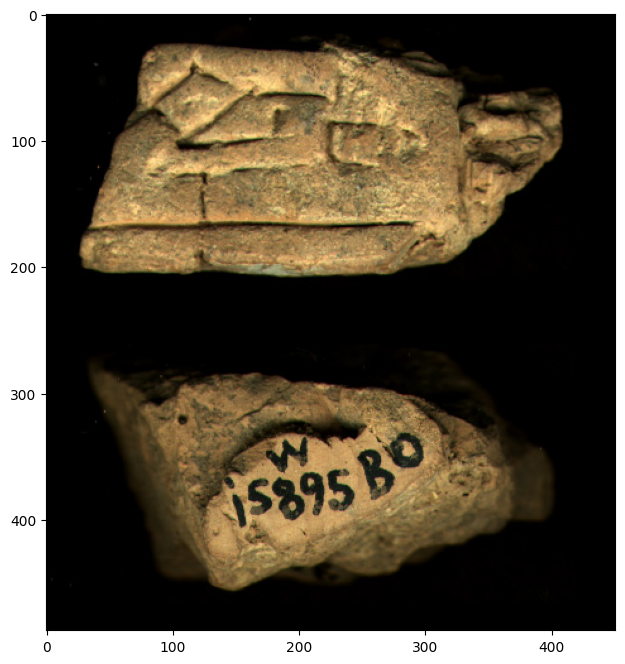

In [15]:
image = Image.open("/trunk/shared/cuneiform/full_data/images/P000109.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(image)

In [6]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
import tqdm
import json
# !{sys.executable} -m pip install opencv-python matplotlib
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import sys
import numpy as np
from PIL import Image
import random
import pickle
from segmentAnythingUtils import *

device = "cuda:2" if torch.cuda.is_available() else "cpu"
random.seed(41)

max_dim = 2000
min_dim = 600

sam_checkpoint = "/trunk/shared/cuneiform/CuneiformDating/image_classification/segmentation/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.94,
    stability_score_thresh=0.90,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10000,  # Requires open-cv to run post-processing
)

# ids_path = "/trunk/shared/cuneiform/CuneiformDating/image_classification/segmentation/code/temp_results/run_segmentation_again.json"
ids_path = "/trunk/shared/cuneiform/full_data/all_ids.json"

with open(ids_path, 'r') as f:
    all_ids = json.load(f)

print("Total images to segment:", len(all_ids))

image_anno = json.load(open("/trunk2/datasets/cuneiform/image_anno.json", 'r'))

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True
Total images to segment: 56694


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 85/100 [00:01<00:00, 103.11it/s]

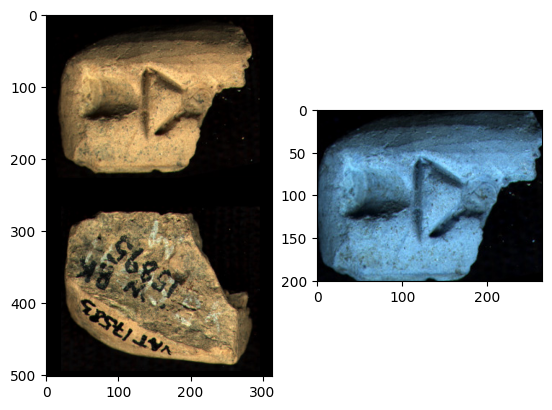

106


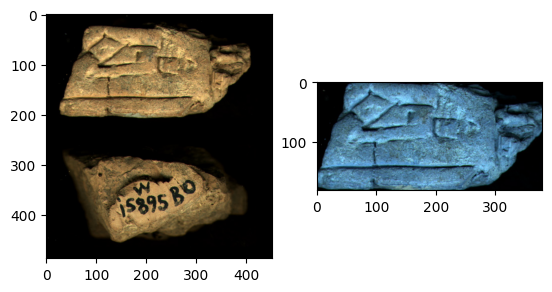

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.58it/s]

109


In [7]:
for pid in tqdm.tqdm(all_ids[:100]):

    image_path = "/trunk/shared/cuneiform/full_data/images/"+ "P"+ str(pid).zfill(6)+".jpg"
    masks_filepath = "/trunk/shared/cuneiform/full_data/segmented_mask_info_compressed/P" + str(pid).zfill(6) +".pkl"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    width = image.shape[1]
    height = image.shape[0]


    if not ("RGB" in image_anno[pid].keys() and image_anno[pid]["RGB"] and height<=min_dim and width<=min_dim): 
        #we want to segment only lowres rgb images
        continue

    #adjust contrast for better segmentation
    enhanced_image = image.copy()
    black_mask = image < 30
    enhanced_image[black_mask] = 0

    masks = mask_generator.generate(enhanced_image)
    masks = sorted(masks, key = lambda d: d['area'], reverse = True)
    topFive = masks[:5]

    with open(masks_filepath, 'wb') as f:
        pickle.dump(topFive,f)

    cutout = getFrontCutout(topFive, image)
    cutout = cv2.cvtColor(cutout, cv2.COLOR_BGR2RGB)
    cv2.imwrite("/trunk/shared/cuneiform/full_data/segmented_images/"+ "P"+ str(pid).zfill(6)+".jpg", cutout)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(cutout)
    plt.show()
    print(pid)